In [1]:
import os, sys
import pandas as pd
import numpy as np

#Plot settings
from coffea import hist
from coffea.processor import defaultdict_accumulator

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#Just to efficiently save plots
plot_dir = "/u/gu/dhoang/ldmx_plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")

save_path = plot_dir + dt_string
print("Saving plot to: ", save_path)

# Truth electron's pT simulation
def trigger_weight_truth(pt):
    if pt >= 0.4: #GeV
        return 1.
    else:
        return 0.

# 1D trigger simulation
def trigger_weight_1D(pt, mode = 'loose'):
    
    if mode == 'loose':
        trigger_weight = np.asarray([0.010826347305389221,
                                     0.07083333333333333,
                                     0.3373493975903614,
                                     0.7386363636363636,
                                     0.9541284403669725,
                                     0.9895833333333334,
                                     0.9859154929577465,
                                     0.9824561403508771,
                                     0.92,
                                     0.926829268292683])
    else:
        trigger_weight = np.asarray([0.0011976047904191617,
                                     0.03958333333333333,
                                     0.24899598393574296,
                                     0.6534090909090909,
                                     0.8715596330275229,
                                     0.8854166666666666,
                                     0.8591549295774648,
                                     0.9122807017543859,
                                     0.72,
                                     0.8048780487804879])
        
    
    edges = np.asarray([0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0])/1000.
    
    if pt >= edges[-1]:
        weight = trigger_weight[-1]
    elif pt <= edges[0]:
        weight = 0
    else:
        weight = trigger_weight[(pt >= edges[:-1]) & (pt <= edges[1:])]
        
    return float(weight)

# 2D trigger simulation
def find_pt_indx(pt, pt_edges):
    
    if pt >= pt_edges[-1]:
        pt_indx = -1
    elif pt <= pt_edges[0]:
        pt_indx = 0
    else:
        pt_indx = np.argmax((pt >= pt_edges[:-1]) & (pt <= pt_edges[1:]))
    
    return pt_indx

def find_e_indx(E, e_edges):
    
    if E >= e_edges[-1]:
        e_indx = -1
    elif E <= e_edges[0]:
        e_indx = 0
    else:
        e_indx = np.argmax((E >= e_edges[:-1]) & (E <= e_edges[1:]))
    
    return e_indx

def trigger_weight_2D(pt, E, mode = 'loose'):
    
    if mode == 'loose':
        trigger_weight = np.load("loose_trigger.npy")
    else:
        trigger_weight = np.load("tight_trigger.npy")
        
    
    pt_edges = np.asarray([0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0])/1000.
    e_edges = np.asarray([0.0, 400.0, 800.0, 1200.0, 1600.0, 2000.0, 2400.0, 2800.0, 3200.0, 3600.0, 4000.0])/1000.
    
    #Find the index
    pt_indx = None
    e_indx = None
    
    pt_indx = find_pt_indx(pt, pt_edges)
    e_indx = find_e_indx(E, e_edges)
    
    if np.isnan(trigger_weight[pt_indx, e_indx]):
        return 0.
    else:
        return float(trigger_weight[pt_indx, e_indx]) 

Saving plot to:  /u/gu/dhoang/ldmx_plot/05-04-2021


## 2. Processor

In [2]:
hists = {}

hists["Q_squared"] = hist.Hist("Events", hist.Cat("sample", "Sample name"),
                               hist.Bin("q2", r"$Q^2$ [$GeV^2$]", np.logspace(-2, 1, 20)))

hists["omega"] = hist.Hist("Events", hist.Cat("sample", "Sample name"),
                          hist.Bin("omega", "$\omega$ [GeV]",np.logspace(-1, 1, 20)))

hists["lepton_pt"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("pt", r"Final State Lepton $p_{T}$ [GeV/c]", 20, 0, 1))
hists["lepton_e"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("e", r"Final State Lepton E [GeV]", 20, 0, 4))

hists["p1_pt"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("pt", r"Final State Proton $p_{T}$ [GeV/c]", 20, 0, 1.6))
hists["p1_e"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("e", r"Final State Proton E [GeV]", 20, 0, 4))
hists["p1_ke"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("ke", r"Final State Proton KE [GeV]", 20, 0, 4))

hists["n1_pt"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("pt", r"Final State Neutron $p_{T}$ [GeV/c]", 20, 0, 1.6))
hists["n1_e"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("e", r"Final State Neutron E [GeV]", 20, 0, 4))
hists["n1_ke"] = hist.Hist("Events", hist.Cat("sample", "Sample name"), 
                               hist.Bin("ke", r"Final State Neutron KE [GeV]", 20, 0, 4))

In [4]:
def processor(file_name, config_mode = 'loose'):
    
    gst_df = pd.read_hdf(file_name, key="gst_df")

    query='index' #all
    df=gst_df.query(query)
    
    #Varibale parameters
    wght="MFP_pi"
    sigma=1
    units="GeV/c"
    Eb = 4.0
     
    #Different trigger sim mode
    truth_pt_weight = df['ptl'].apply(trigger_weight_truth).to_numpy()
    weight_trigger_1D = df['ptl'].apply(trigger_weight_1D, mode = config_mode).to_numpy()
    weight_trigger_2D = df.apply(lambda x: trigger_weight_2D(x.ptl, x.El, mode = config_mode), axis = 1).to_numpy()
    
    CV_weight = df["wght"].to_numpy()

    #Calculate Q2 and omega
    lepton_e = df['El'].to_numpy()
    lepton_pt = df['ptl'].to_numpy()
    
    omega = Eb - lepton_e #GeV
    Q2 = 2*Eb*(Eb-omega)*(1-np.cos(np.arcsin(lepton_pt/(Eb-omega))))
    
    #omega
    hists["omega"].fill(sample = 'Truth $e^{-}$ $p_T$', omega = omega, weight = truth_pt_weight*CV_weight)
    hists["omega"].fill(sample = '1D trigger sim', omega = omega, weight= weight_trigger_1D*CV_weight)
    hists["omega"].fill(sample = '2D trigger sim', omega = omega, weight= weight_trigger_2D*CV_weight)
    
    #Q^2
    hists["Q_squared"].fill(sample = 'Truth $e^{-}$ $p_T$', q2 = Q2, weight = truth_pt_weight*CV_weight)
    hists["Q_squared"].fill(sample = '1D trigger sim', q2 = Q2,
                            weight= weight_trigger_1D*CV_weight)
    hists["Q_squared"].fill(sample = '2D trigger sim', q2 = Q2,
                            weight= weight_trigger_2D*CV_weight)
    
    #--------------------LEADING LEPTONS
    #Lepton's pT
    lepton_pt = df['ptl'].to_numpy()
    
    hists["lepton_pt"].fill(sample = 'Truth $e^{-}$ $p_T$', pt = lepton_pt, weight = truth_pt_weight*CV_weight)
    
    hists["lepton_pt"].fill(sample = '1D trigger sim', pt = lepton_pt,
                           weight= weight_trigger_1D*CV_weight)
    
    hists["lepton_pt"].fill(sample = '2D trigger sim', pt = lepton_pt,
                            weight= weight_trigger_2D*CV_weight)
    
    #Energy of lepton
    lepton_e = df['El'].to_numpy()
    hists["lepton_e"].fill(sample = 'Truth $e^{-}$ $p_T$', e = lepton_e, weight = truth_pt_weight*CV_weight)
    
    hists["lepton_e"].fill(sample = '1D trigger sim', e = lepton_e,
                            weight= weight_trigger_1D*CV_weight)
    
    hists["lepton_e"].fill(sample = '2D trigger sim', e = lepton_e,
                            weight= weight_trigger_2D*CV_weight)
    
    #--------------------LEADING PROTONS
    proton_pt = np.hypot(df['px_p1'], df['py_p1']).to_numpy()
    
    #Proton pt
    hists["p1_pt"].fill(sample = 'Truth $e^{-}$ $p_T$', pt = proton_pt, weight = truth_pt_weight*CV_weight)
    
    hists["p1_pt"].fill(sample = '1D trigger sim', pt = proton_pt,
                       weight= weight_trigger_1D*CV_weight)
    
    hists["p1_pt"].fill(sample = '2D trigger sim', pt = proton_pt,
                        weight= weight_trigger_2D*CV_weight)
    #Proton Energy
    proton_e = df['E_p1'].to_numpy()
    hists["p1_e"].fill(sample = 'Truth $e^{-}$ $p_T$', e = proton_e, weight = truth_pt_weight*CV_weight)
    
    hists["p1_e"].fill(sample = '1D trigger sim', e = proton_e,
                       weight= weight_trigger_1D*CV_weight)
    
    hists["p1_e"].fill(sample = '2D trigger sim', e = proton_e,
                        weight= weight_trigger_2D*CV_weight)
    
    #Proton Kinetic Energy
    proton_ke = df['ke_p1'].to_numpy()
    hists["p1_ke"].fill(sample = 'Truth $e^{-}$ $p_T$', ke = proton_ke, weight = truth_pt_weight*CV_weight)
    hists["p1_ke"].fill(sample = '1D trigger sim', ke = proton_ke,
                       weight= weight_trigger_1D*CV_weight)
    hists["p1_ke"].fill(sample = '2D trigger sim', ke = proton_ke,
                        weight= weight_trigger_2D*CV_weight)
    
    #--------------------LEADING NEUTRONs
    neutron_pt = np.hypot(df['px_n1'], df['py_n1']).to_numpy()
    
    #Neutron pt
    hists["n1_pt"].fill(sample = 'Truth $e^{-}$ $p_T$', pt = neutron_pt, weight = truth_pt_weight*CV_weight)
    
    hists["n1_pt"].fill(sample = '1D trigger sim', pt = neutron_pt,
                       weight= weight_trigger_1D*CV_weight)
    
    hists["n1_pt"].fill(sample = '2D trigger sim', pt = neutron_pt,
                         weight= weight_trigger_2D*CV_weight)
    #Neutron Energy
    neutron_e = df['E_n1'].to_numpy()
    hists["n1_e"].fill(sample = 'Truth $e^{-}$ $p_T$', e = neutron_e, weight = truth_pt_weight*CV_weight)
    
    hists["n1_e"].fill(sample = '1D trigger sim', e = neutron_e,
                       weight= weight_trigger_1D*CV_weight)
    
    hists["n1_e"].fill(sample = '2D trigger sim', e = neutron_e,
                       weight= weight_trigger_2D*CV_weight)
    
    #Proton Kinetic Energy
    neutron_ke = df['ke_n1'].to_numpy()
    hists["n1_ke"].fill(sample = 'Truth $e^{-}$ $p_T$', ke = neutron_ke, weight = truth_pt_weight*CV_weight)
    hists["n1_ke"].fill(sample = '1D trigger sim', ke = neutron_ke,
                        weight= weight_trigger_1D*CV_weight)
    hists["n1_ke"].fill(sample = '2D trigger sim', ke = neutron_ke,
                        weight= weight_trigger_2D*CV_weight)
    
    %reset -f in

## 1. Loose configuration

In [4]:
chunk = 0

for filename in os.listdir("../data/"):
    if filename.startswith("base_generation_with_weights_02Mar21_"):
        f_path = os.path.join("../data/", filename)
        processor(f_path)
        
        chunk += 1
#        if chunk == 1:
#            break

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


/u/gu/dhoang/ldmx_plot/05-04-2021final_state_l_pt_loose_trigger_comp.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


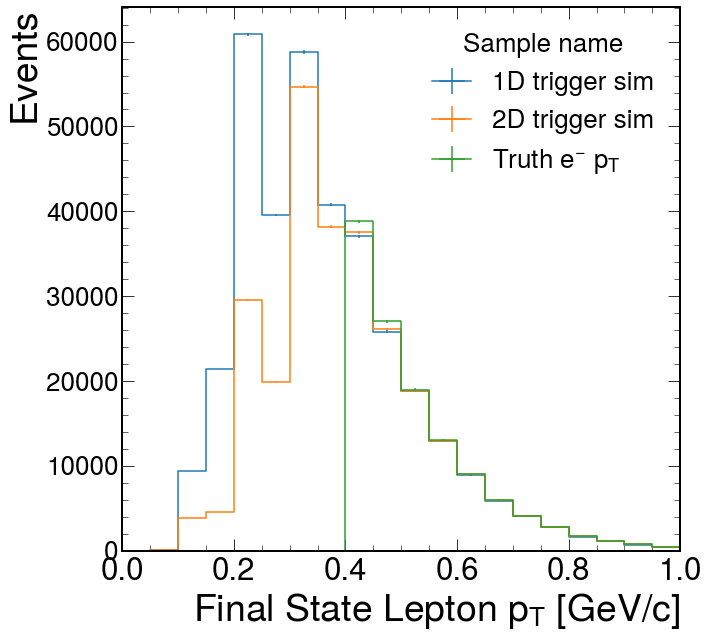

In [5]:
hist.plot1d(hists["lepton_pt"])
print(save_path + "final_state_l_pt_loose_trigger_comp.pdf")
plt.savefig(save_path + "final_state_l_pt_loose_trigger_comp.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021final_state_e_pt_loose_trigger_comp.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


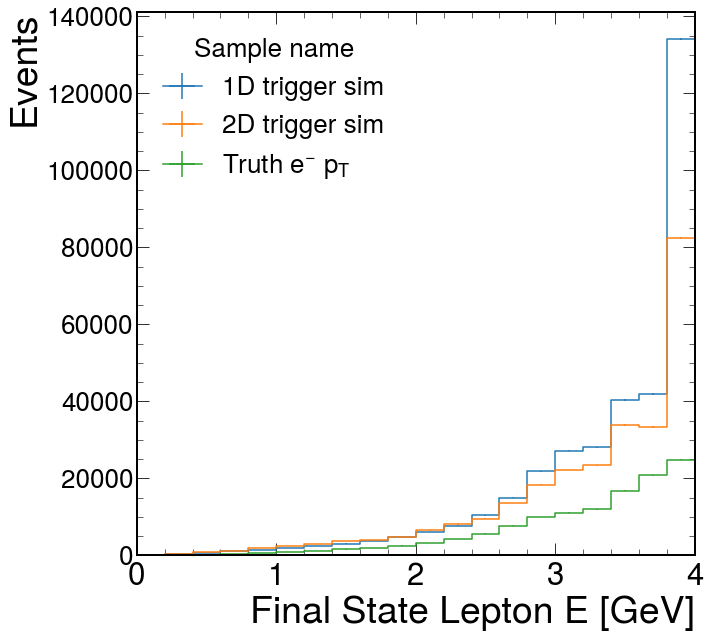

In [6]:
hist.plot1d(hists["lepton_e"])
print(save_path + "final_state_e_pt_loose_trigger_comp.pdf")
plt.savefig(save_path + "final_state_e_pt_loose_trigger_comp.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021final_state_p1_pt_loose_trigger_comp.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


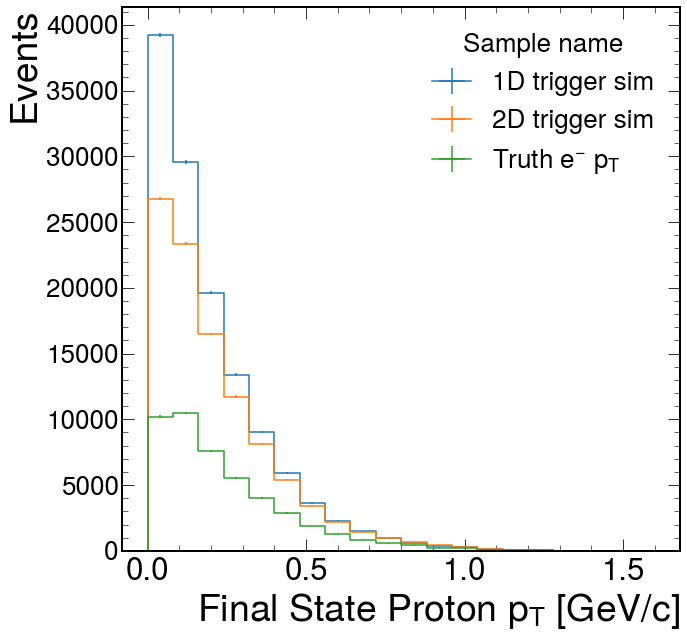

In [8]:
hist.plot1d(hists["p1_pt"], overflow = 'all')
print(save_path + "final_state_p1_pt_loose_trigger_comp.pdf")
plt.savefig(save_path + "final_state_p1_pt_loose_trigger_comp.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021final_state_p1_e_loose_trigger_comp.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


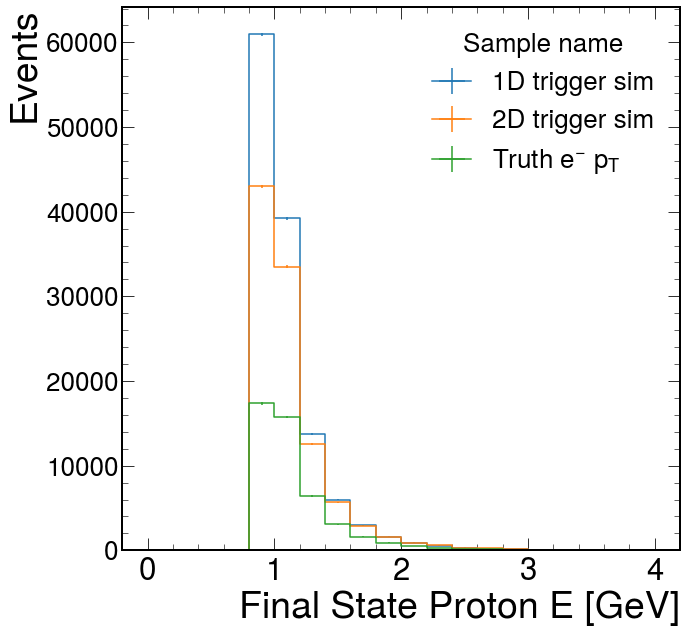

In [9]:
hist.plot1d(hists["p1_e"], overflow = 'all')
print(save_path + "final_state_p1_e_loose_trigger_comp.pdf")
plt.savefig(save_path + "final_state_p1_e_loose_trigger_comp.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021final_state_p1_ke_loose_trigger_comp.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


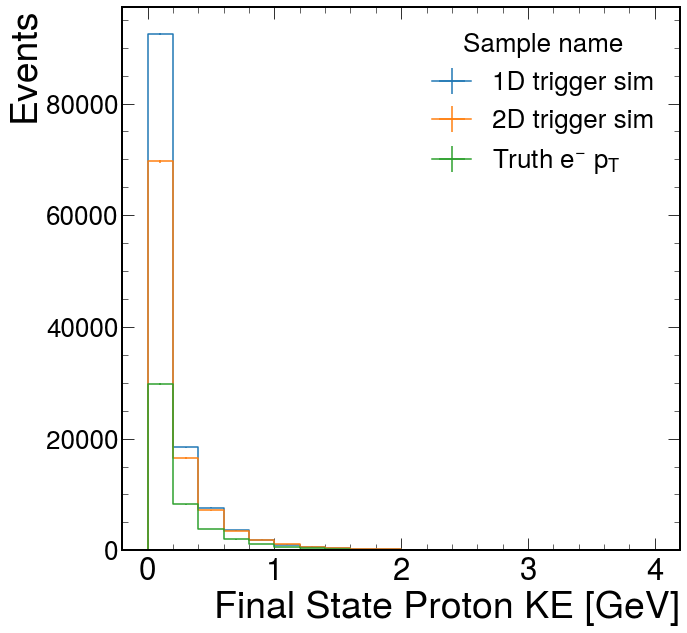

In [10]:
hist.plot1d(hists["p1_ke"], overflow = 'all')
print(save_path + "final_state_p1_ke_loose_trigger_comp.pdf")
plt.savefig(save_path + "final_state_p1_ke__loose_trigger_comp.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021final_state_n1_pt_loose_trigger_comp.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


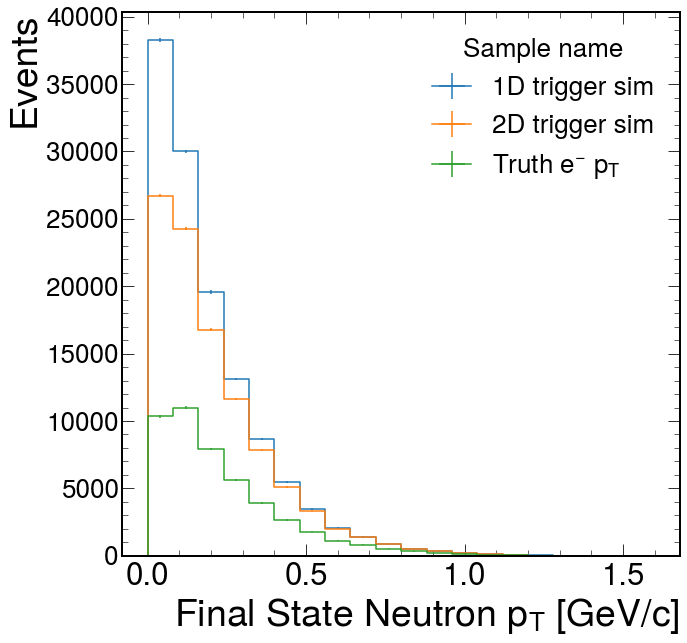

In [11]:
hist.plot1d(hists["n1_pt"], overflow = 'all')
print(save_path + "final_state_n1_pt_loose_trigger_comp.pdf")
plt.savefig(save_path + "final_state_n1_pt_loose_trigger_comp.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021final_state_n1_e_loose_trigger_comp.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


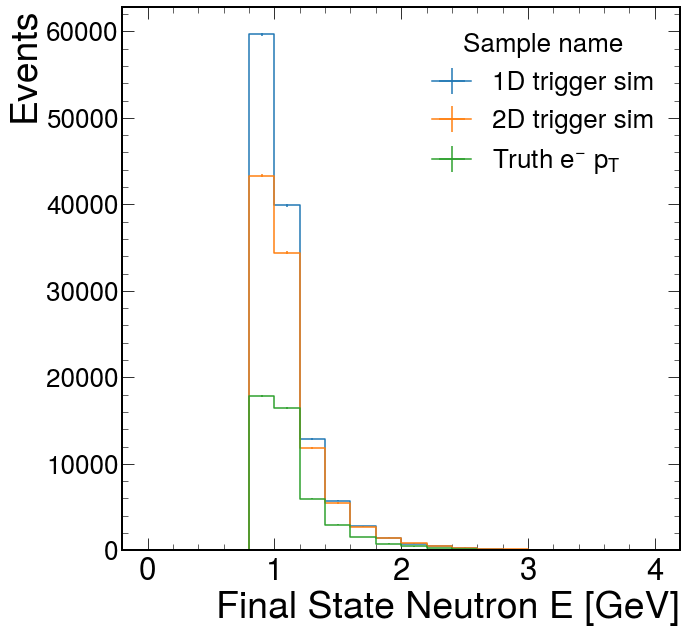

In [12]:
hist.plot1d(hists["n1_e"], overflow = 'all')
print(save_path + "final_state_n1_e_loose_trigger_comp.pdf")
plt.savefig(save_path + "final_state_n1_e_loose_trigger_comp.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021final_state_n1_ke_loose_trigger_comp.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


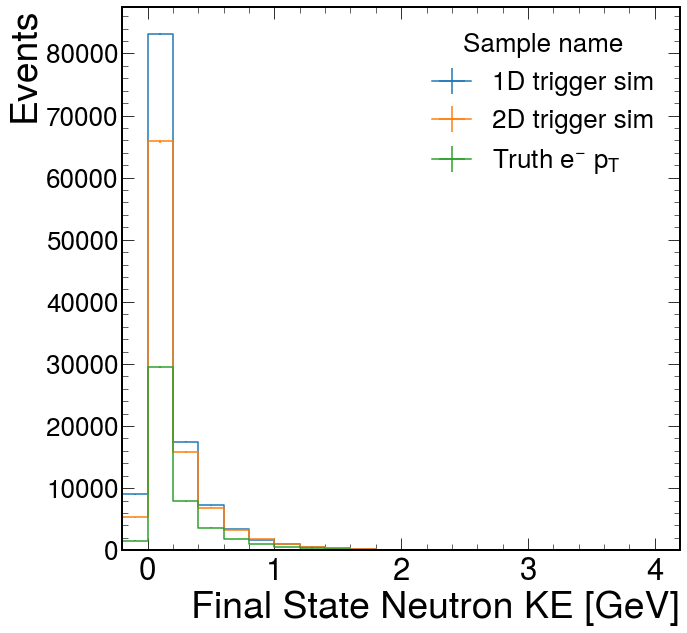

In [13]:
hist.plot1d(hists["n1_ke"], overflow = 'all')
print(save_path + "final_state_n1_ke_loose_trigger_comp.pdf")
plt.savefig(save_path + "final_state_n1_ke_loose_trigger_comp.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021omega_loose_trigger_comparison.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


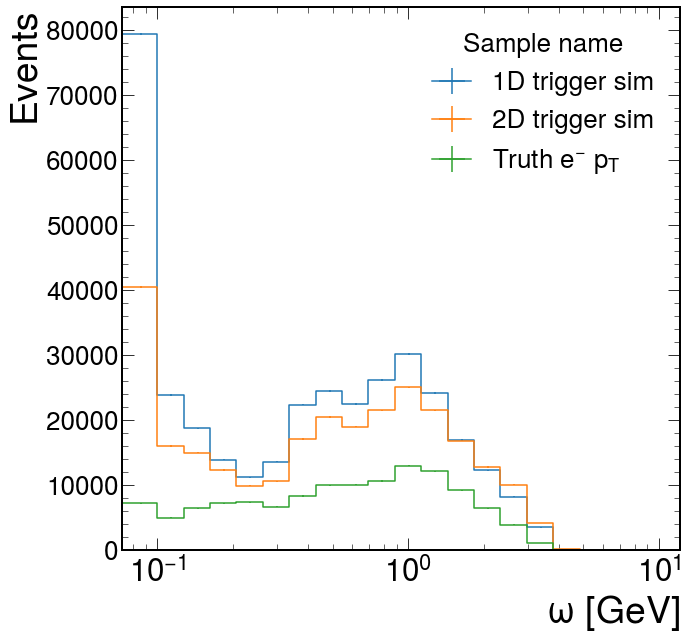

In [7]:
hist.plot1d(hists["omega"], overflow = 'all')
plt.xscale('log')
print(save_path + "omega_loose_trigger_comparison.pdf")
plt.savefig(save_path + "omega_loose_trigger_comparison.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021Q2_loose_trigger_comparison.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


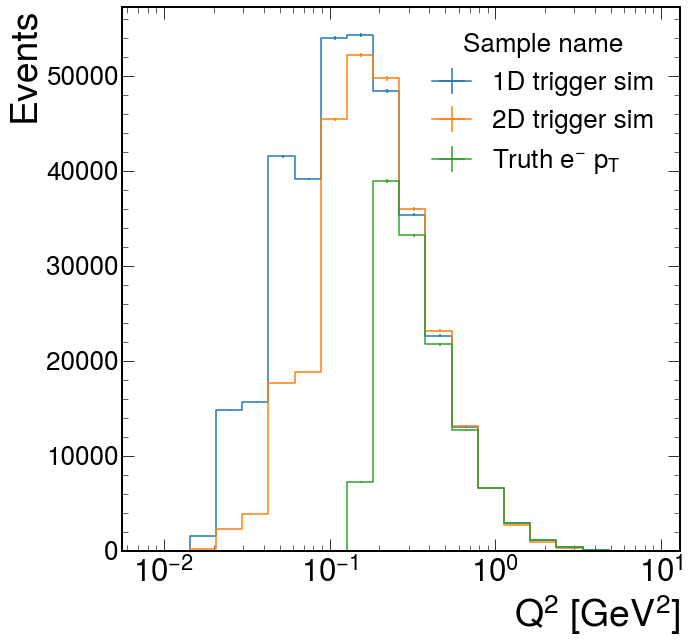

In [8]:
hist.plot1d(hists["Q_squared"], overflow = 'all')
plt.xscale('log')
print(save_path + "Q2_loose_trigger_comparison.pdf")
plt.savefig(save_path +  "Q2_loose_trigger_comparison.pdf", bbox_inches = 'tight')

## 2. Tight configuration

In [5]:
chunk = 0

for filename in os.listdir("../data/"):
    if filename.startswith("base_generation_with_weights_02Mar21_"):
        f_path = os.path.join("../data/", filename)
        processor(f_path, config_mode = 'tight')
        
        chunk += 1
#        if chunk == 1:
#            break

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


/u/gu/dhoang/ldmx_plot/05-04-2021final_state_l_pt_tight_trigger_comp.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


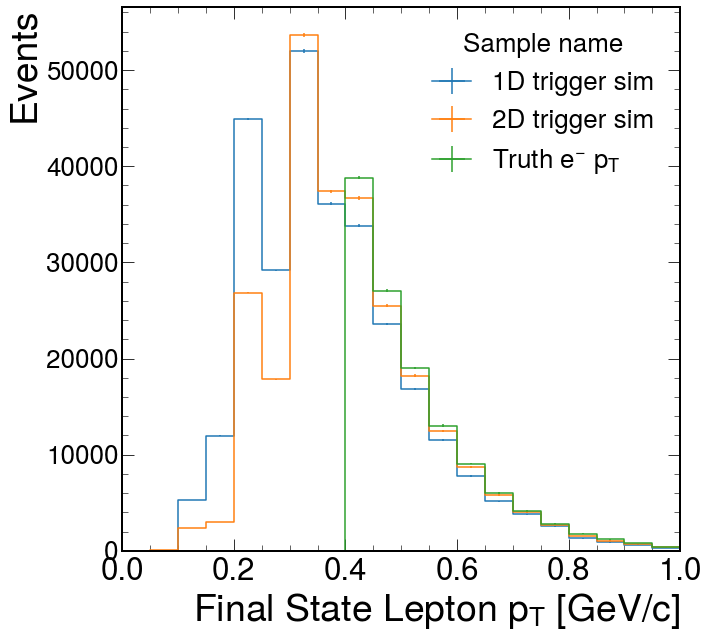

In [6]:
hist.plot1d(hists["lepton_pt"])
print(save_path + "final_state_l_pt_tight_trigger_comp.pdf")
plt.savefig(save_path + "final_state_l_pt_tight_trigger_comp.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021final_state_l_e_tight_trigger_comp.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


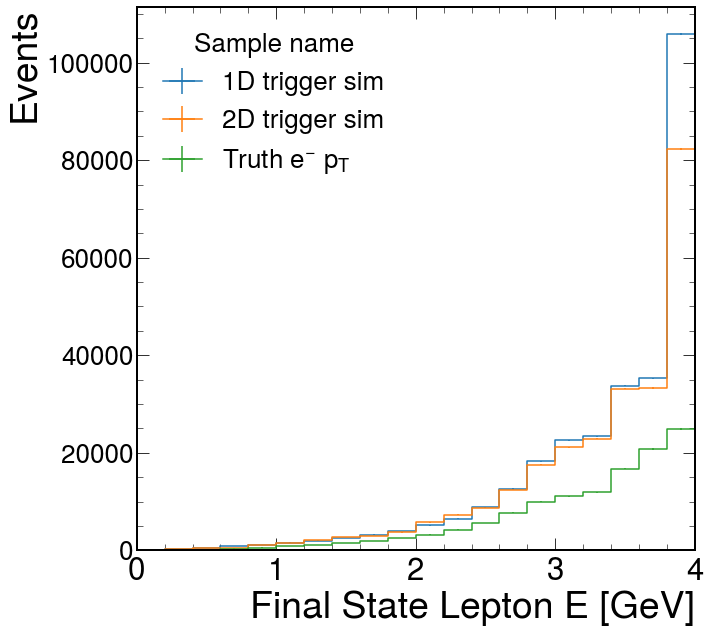

In [7]:
hist.plot1d(hists["lepton_e"])
print(save_path + "final_state_l_e_tight_trigger_comp.pdf")
plt.savefig(save_path + "final_state_l_e_tight_trigger_comp.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021final_state_p1_pt_tight_trigger_comp.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


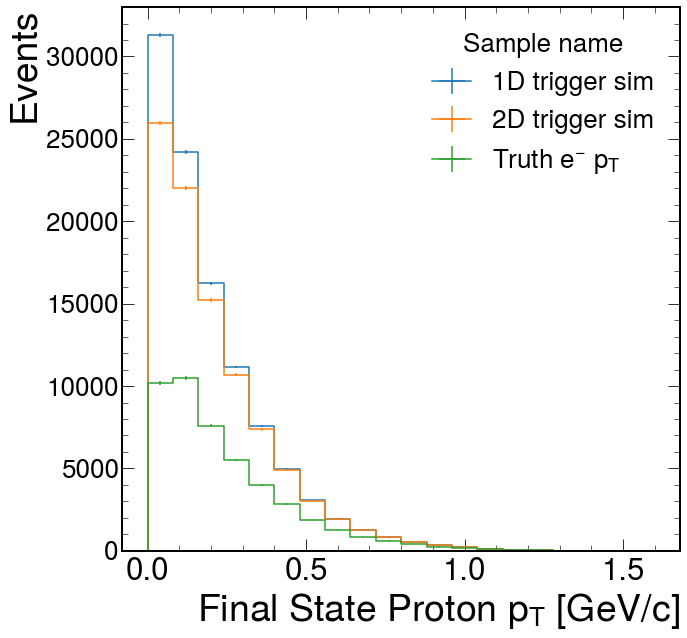

In [8]:
hist.plot1d(hists["p1_pt"], overflow = 'all')
print(save_path + "final_state_p1_pt_tight_trigger_comp.pdf")
plt.savefig(save_path + "final_state_p1_pt_tight_trigger_comp.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021final_state_p1_e_tight_trigger_comp.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


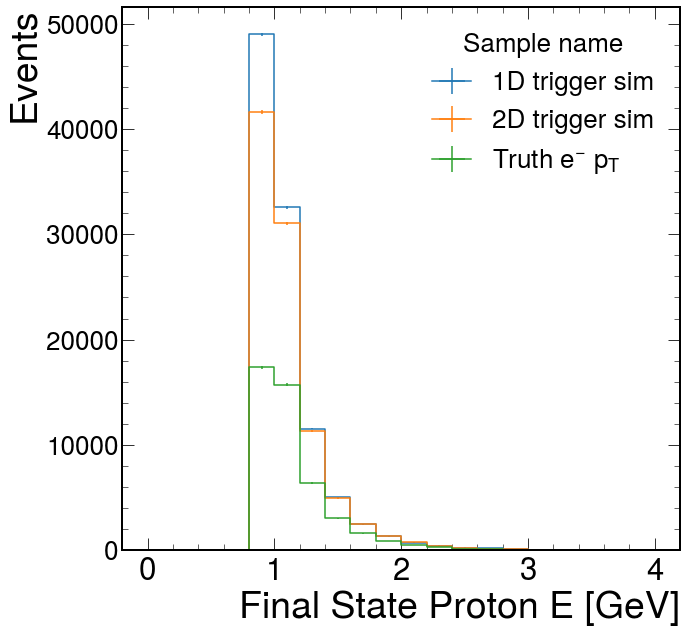

In [9]:
hist.plot1d(hists["p1_e"], overflow = 'all')
print(save_path + "final_state_p1_e_tight_trigger_comp.pdf")
plt.savefig(save_path + "final_state_p1_e_tight_trigger_comp.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021final_state_p1_ke_tight_trigger_comp.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


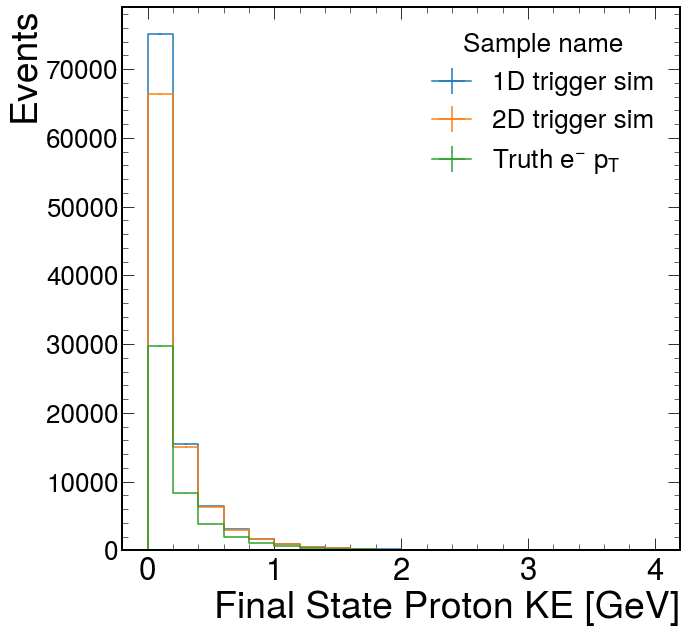

In [10]:
hist.plot1d(hists["p1_ke"], overflow = 'all')
print(save_path + "final_state_p1_ke_tight_trigger_comp.pdf")
plt.savefig(save_path + "final_state_p1_ke__tight_trigger_comp.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021final_state_n1_pt_tight_trigger_comp.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


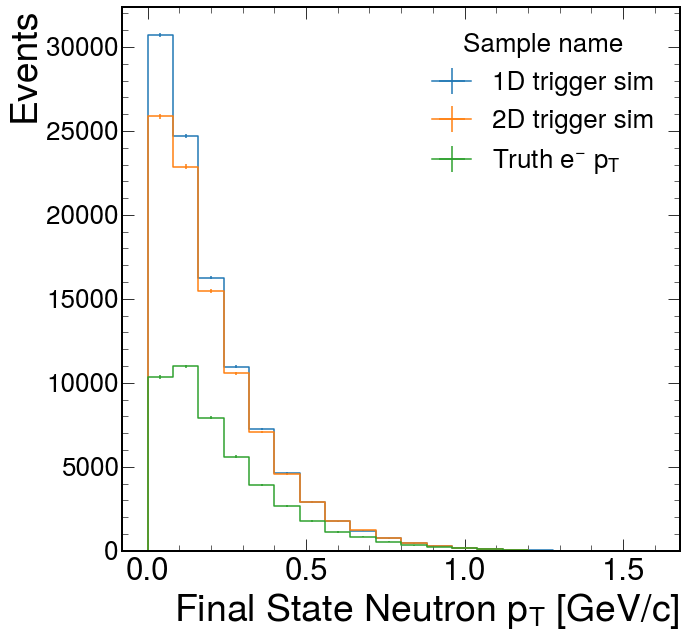

In [11]:
hist.plot1d(hists["n1_pt"], overflow = 'all')
print(save_path + "final_state_n1_pt_tight_trigger_comp.pdf")
plt.savefig(save_path + "final_state_n1_pt_tight_trigger_comp.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021final_state_n1_e_tight_trigger_comp.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


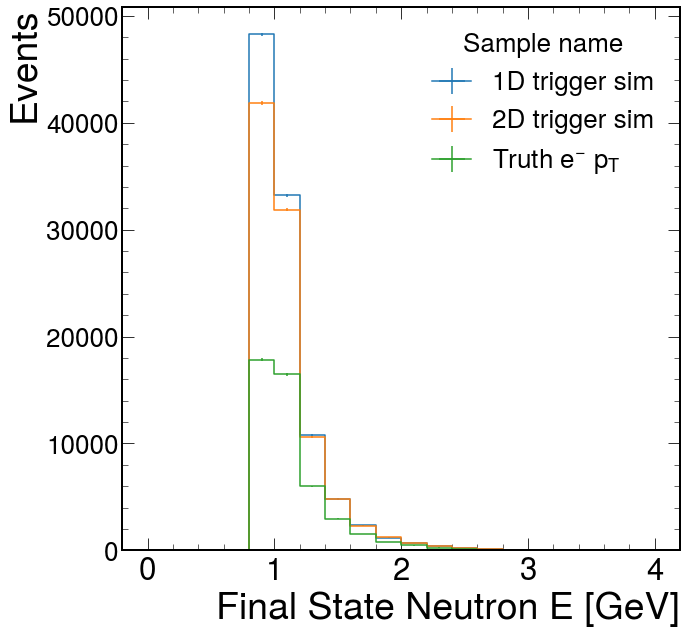

In [12]:
hist.plot1d(hists["n1_e"], overflow = 'all')
print(save_path + "final_state_n1_e_tight_trigger_comp.pdf")
plt.savefig(save_path + "final_state_n1_e_tight_trigger_comp.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021final_state_n1_ke_tight_trigger_comp.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


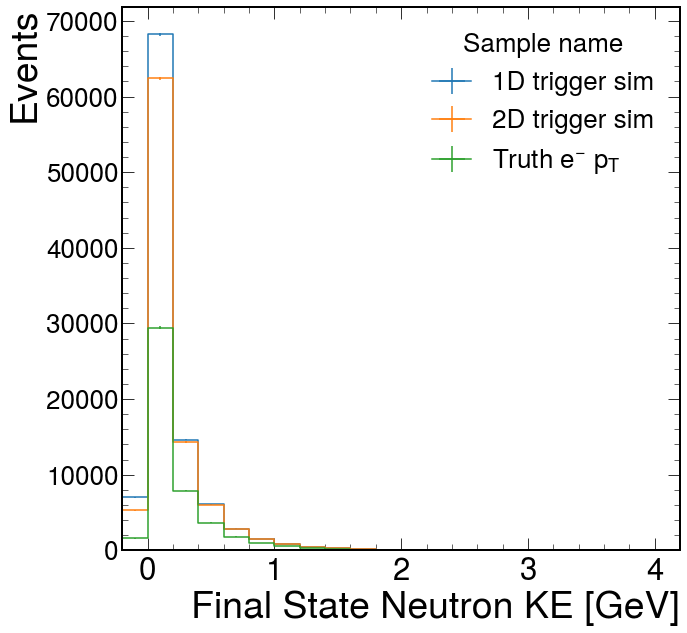

In [13]:
hist.plot1d(hists["n1_ke"], overflow = 'all')
print(save_path + "final_state_n1_ke_tight_trigger_comp.pdf")
plt.savefig(save_path + "final_state_n1_ke_tight_trigger_comp.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021omega_tight_trigger_comparison.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


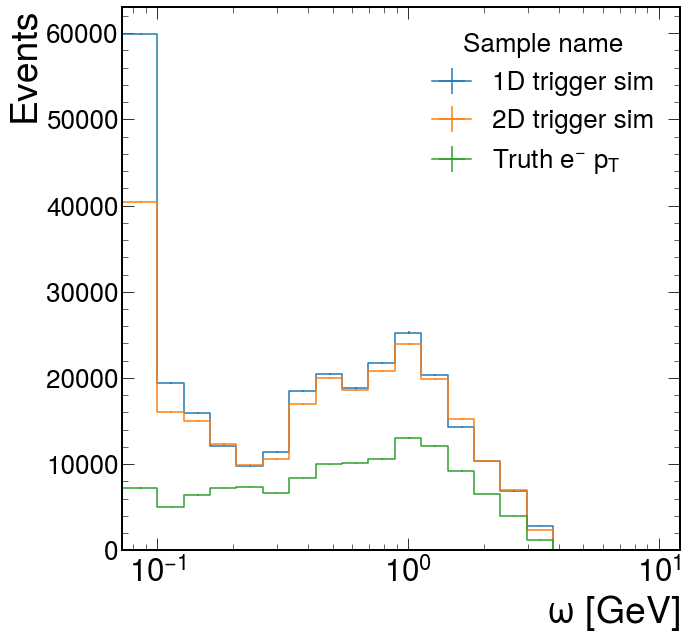

In [6]:
hist.plot1d(hists["omega"], overflow = 'all')
plt.xscale('log')
print(save_path + "omega_tight_trigger_comparison.pdf")
plt.savefig(save_path + "omega_tight_trigger_comparison.pdf", bbox_inches = 'tight')

/u/gu/dhoang/ldmx_plot/05-04-2021Q2_tight_trigger_comparison.pdf


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


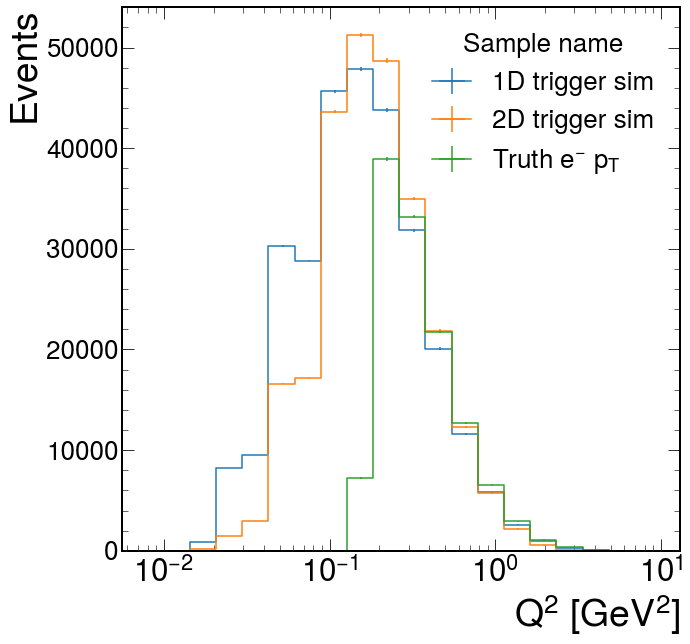

In [7]:
hist.plot1d(hists["Q_squared"], overflow = 'all')
plt.xscale('log')
print(save_path + "Q2_tight_trigger_comparison.pdf")
plt.savefig(save_path +  "Q2_tight_trigger_comparison.pdf", bbox_inches = 'tight')